In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri
import scanorama

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==0.25.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.2


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/singlecell/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

### Import dataset

In [4]:
adata = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/NotCorrected_T_cell.h5ad")

In [9]:
adataR06K20 = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/adataR06K20_clustered_louvain06.h5ad")

### Filter out only CD4

In [14]:
adata_sub = adataR06K20[adataR06K20.obs['T_cell_main_type'].isin(['CD4']),:]

In [95]:
adata_sub.shape

(8798, 18811)

In [17]:
adata = adata[adata_sub.obs_names]

In [18]:
adata.raw = adata

### Metrics

In [24]:
pd.crosstab(adata.obs.dataset, adata.obs.TumorType)

TumorType,BC,CRC,IBD,Lung,Ovarian,RA,SLE
dataset,,,,,,,
10X 3 V2,0,1379,3032,325,263,0,0
10X 5 V2,3025,0,0,0,0,0,0
CellSeq,0,0,0,0,0,617,157


### Compute high variable genes

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


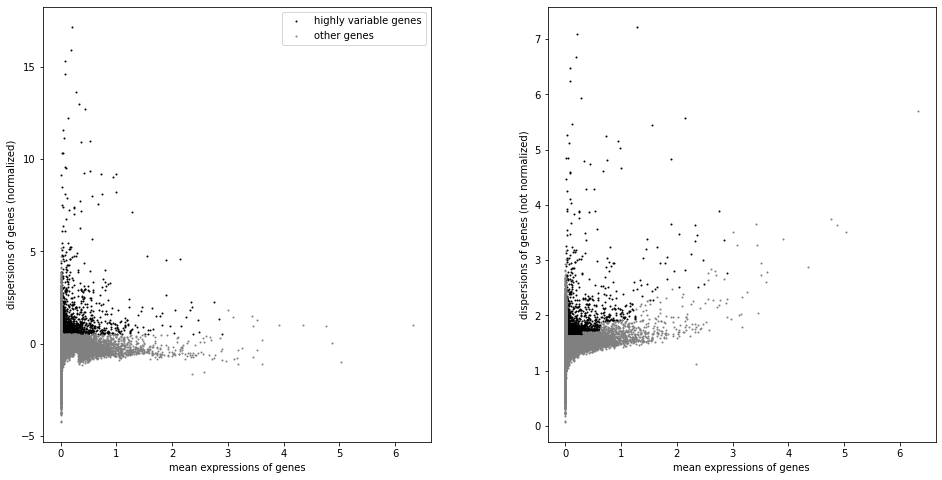

Highly variable genes: 1825


In [25]:
#variable genes for the full dataset
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata)

print("Highly variable genes: %d"%sum(adata.var.highly_variable))

var_genes_all = adata.var.highly_variable

normalizing counts per cell
    finished (0:00:00)


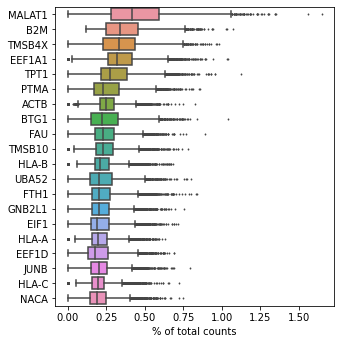

In [27]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [28]:
import desc
import keras
keras.__version__
import pydot
pydot.__version__

'1.4.1'

### DESC - Deep learning

In [7]:
def run_vis(adata):
    if 'X_emb' in adata.obsm:
        sc.pp.neighbors(adata, use_rep='X_emb')
        sc.tl.umap(adata)
    else:
        sc.pp.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)

In [30]:
out = adata.copy()

In [ ]:
out = desc.scale_bygroup(out, groupby='dataset', max_value=6)
out = desc.train(out,
                     dims=[adata.shape[1],128,32],
                     tol=0.001,
                     n_neighbors=15,
                     batch_size=256,
                     louvain_resolution=[0.3,0.4,0.5,0.6,0.7,0.8],
                     save_encoder_weights=False,
                     save_dir="/home/spuccio/isilon/TempFolder",
                     do_tsne=False,
                     use_GPU=False,
                     num_Cores=30,
                     use_ae_weights=False,
                     do_umap=False)

### Clustree

In [33]:
data_clus = out.obs[['desc_0.6','desc_0.3','desc_0.4','desc_0.5','desc_0.7','desc_0.8']]

In [34]:
data_clus.columns = ['louvain_r6_clusters','louvain_r3_clusters','louvain_r4_clusters','louvain_r5_clusters','louvain_r7_clusters','louvain_r8_clusters']

In [35]:
data_clus.to_csv("/mnt/lugli/SP028_Autoimmunity/h5_files/temp.csv",index=True,header=True)

In [36]:
data_clus = pd.read_csv("/mnt/lugli/SP028_Autoimmunity/h5_files/temp.csv",index_col=0,header=0)

In [37]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command
import rpy2
old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

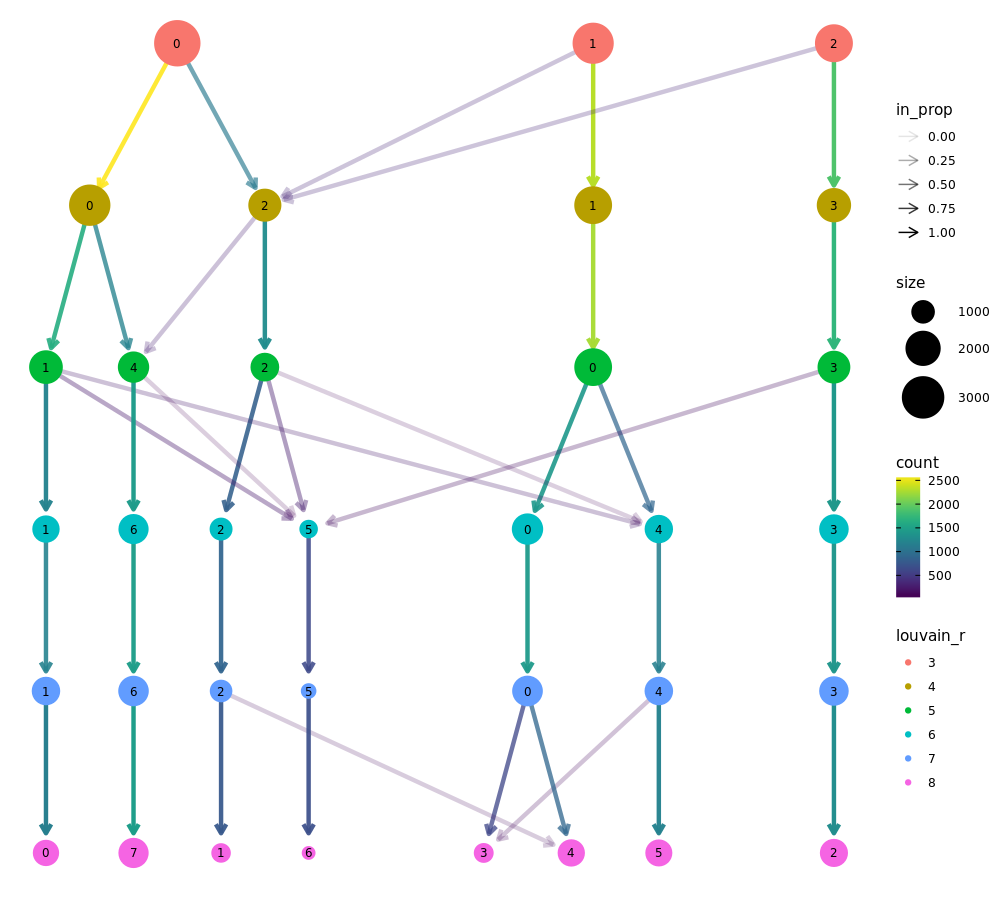

In [38]:
%%R -i data_clus
library(clustree)

clustree(data_clus,prefix="louvain_r",suffix = "_clusters") 

#### Cells x cluster

In [5]:
out.obs['desc_0.4'].value_counts()

0    2825
1    2320
3    1896
2    1757
Name: desc_0.4, dtype: int64

### Umap Plot

In [8]:
out.obsm['X_emb'] = out.obsm['X_Embeded_z'+str(0.4)]
run_vis(out)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


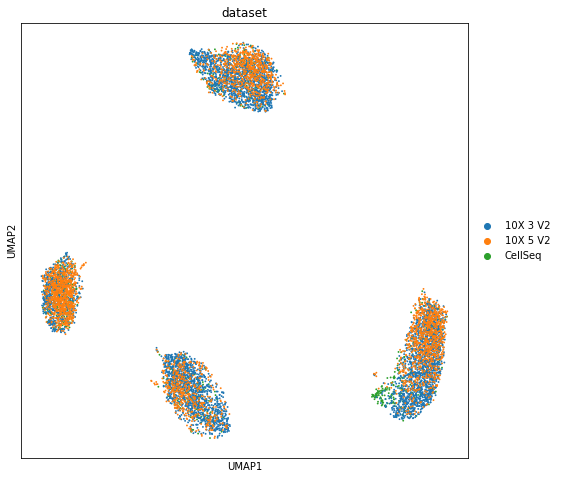

In [9]:
sc.pl.umap(out, color='dataset'); plt.show()

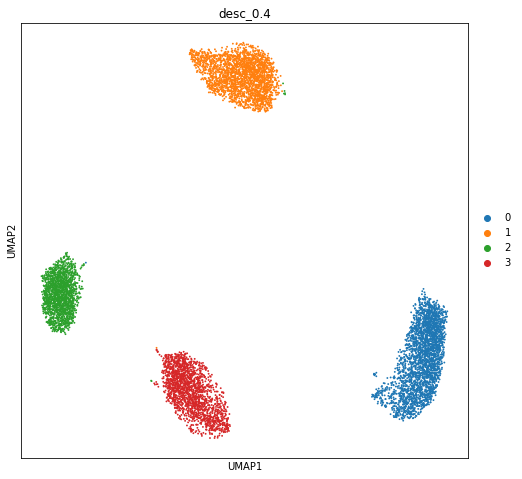

In [10]:
sc.pl.umap(out, color='desc_0.4'); plt.show()

In [11]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

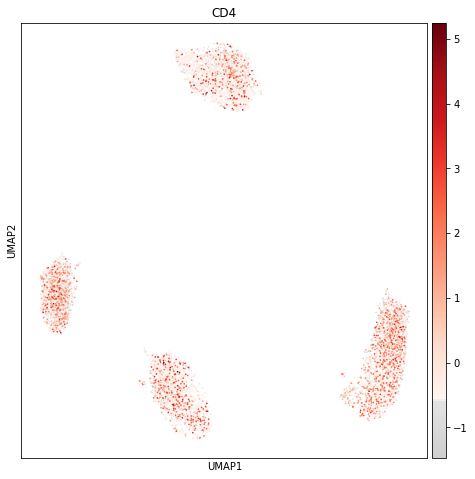

In [12]:
sc.pl.umap(out, color=['CD4'],color_map=mymap,use_raw=False,s=10); plt.show()

### Compute DEGS

In [13]:
#sc.pp.scale(adata,max_value=10)
sc.tl.rank_genes_groups(out, 'desc_0.4', method='t-test', key_added = "t-test",use_raw=True)

ranking genes
    finished: added to `.uns['t-test']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


In [14]:
pd.DataFrame(out.uns['t-test']['names']).head(20)

,0,1,2,3
0,CD52,EEF1B2,ANXA1,RGS1
1,S100A6,TPT1,ZFP36,SRGN
2,S100A11,IGHA1,DUSP2,B2M
3,VIM,NUCB2,VIM,SAT1
4,TXNIP,PLAC8,HLA-B,CREM
5,LTB,MALAT1,HLA-C,ARID5B
6,S100A4,BTG1,UBC,DUSP4
7,PFN1,ATXN8OS,NR4A2,BATF
8,TMSB10,AREG,TNFAIP3,CTLA4
9,MYL12A,CD3E,ZFP36L2,RORA


In [ ]:
#fig, (ax1,ax2,ax3,ax4) = plt.subplots(2,2, figsize=(33/2.54, 17/2.54))
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,figsize=(33/2.54, 17/2.54))
sc.pl.umap(adataR06K20, color="leiden_r6_clusters",legend_loc="on data",ax=ax1, show=False)
ax2 = adataR06K20.obs.groupby("leiden_r6_clusters")["TumorType"].value_counts().unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster ")
ax2.set_ylabel("% Frequency Disease")
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.1, 1.0))
ax3 = adataR06K20.obs.groupby("leiden_r6_clusters")["CellFromTumor"].value_counts().unstack().plot.bar(stacked=True,legend=False,ax=ax3)
ax3.set_xlabel("Cluster ")
ax3.set_ylabel("% Frequency SampleType")
ax3.grid(False)
ax3.legend()
ax4 = adataR06K20.obs.groupby("leiden_r6_clusters")["dataset"].value_counts().unstack().plot.bar(stacked=True,legend=False,ax=ax4)
ax4.set_xlabel("Cluster ")
ax4.set_ylabel("% Frequency Technology")
ax4.grid(False)
ax4.legend(bbox_to_anchor=(1.1, 1.0))

In [15]:
out.obs.groupby("desc_0.4")["CellFromTumor"].value_counts()

desc_0.4  CellFromTumor
0         Tumor            2541
          Autoimmune        284
1         Autoimmune       1469
          Tumor             851
2         Tumor            1087
          Autoimmune        670
3         Autoimmune       1383
          Tumor             513
Name: CellFromTumor, dtype: int64

In [80]:
out.obs[["TumorType","CellFromTumor"]].to_csv("/mnt/lugli/SP028_Autoimmunity/h5_files/temp_tumor.csv",header=False,index=True,sep="\t")

In [83]:
df = pd.read_csv("/mnt/lugli/SP028_Autoimmunity/h5_files/temp_tumor.csv",sep="\t",header=None,index_col=0)

In [85]:
del df[1]

In [86]:
df.head()

,2
0,
S006_L1Q1_A03-0-0,Autoimmune
S006_L1Q1_A09-0-0,Autoimmune
S006_L1Q1_A17-0-0,Autoimmune
S006_L1Q1_C09-0-0,Autoimmune
S006_L1Q1_C11-0-0,Autoimmune


In [89]:
out.obs["CellFromTumor"] = df[2]

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1,

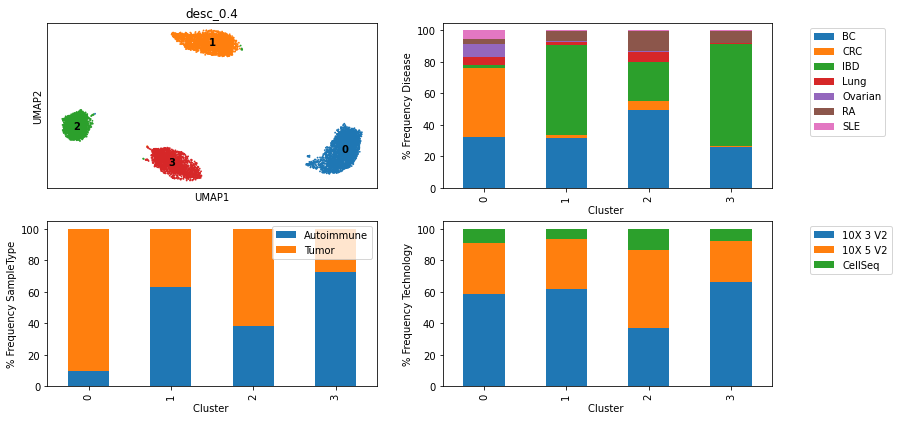

In [16]:
#fig, (ax1,ax2,ax3,ax4) = plt.subplots(2,2, figsize=(33/2.54, 17/2.54))
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,figsize=(33/2.54, 17/2.54))
sc.pl.umap(out, color="desc_0.4",legend_loc="on data",ax=ax1, show=False)
ax2 = out.obs.groupby("desc_0.4")["TumorType"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster ")
ax2.set_ylabel("% Frequency Disease")
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.1, 1.0))
ax3 = out.obs.groupby("desc_0.4")["CellFromTumor"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax3)
ax3.set_xlabel("Cluster ")
ax3.set_ylabel("% Frequency SampleType")
ax3.grid(False)
ax3.legend()
ax4 = out.obs.groupby("desc_0.4")["dataset"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax4)
ax4.set_xlabel("Cluster ")
ax4.set_ylabel("% Frequency Technology")
ax4.grid(False)
ax4.legend(bbox_to_anchor=(1.1, 1.0))

In [17]:
result = out.uns['t-test']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','pvals_adj','logfoldchanges']}).to_csv("/mnt/lugli/SP028_Autoimmunity/h5_files/DEGS_Louvain_clustering_04.tsv",sep="\t",header=True,index=False)

In [18]:
out.write('/mnt/lugli/SP028_Autoimmunity/h5_files/CD4_adata_Res04.h5ad')

In [4]:
out = sc.read_h5ad('/mnt/lugli/SP028_Autoimmunity/h5_files/CD4_adata.h5ad')